In [68]:
import os
import sys
import pandas as pd
from PIL import Image
import numpy as np
import time
import pickle
from IPython import display
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, datasets, utils, models
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [69]:
print("Python version", sys.version)
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

Python version 3.9.17 (main, Jul  5 2023, 20:47:11) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118


# Bit-Wise

In [70]:
import random

def global_seeds(seed_value=0):
    np.random.seed(seed_value) # random seed for the NumPy library
    torch.manual_seed(seed_value) # random seed for PyTorch's CPU-based RNG (random number generator)
    torch.cuda.manual_seed(seed_value) # random seed for PyTorch's GPU-based RNG
    torch.cuda.manual_seed_all(seed_value) # random seed to ensure multiple GPUs are synchronised
    torch.backends.cudnn.deterministic = True # set CuDNN (CUDA Deep Neural Network library) to deterministic
    torch.backends.cudnn.benchmark = False # disable the benchmark mode of CuDNN
    random.seed(seed_value) # python built-in RNG

global_seeds(42)


In [71]:
torch.backends.cudnn.deterministic = False # set CuDNN (CUDA Deep Neural Network library) to deterministic
torch.backends.cudnn.benchmark = False

In [72]:
cifar10trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar10testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, data, labels, random_crop = False, random_rotation = False, resize = False):
        self.data = data
        self.labels = labels
        transforms_list = [
            transforms.ToTensor(),  # Convert to tensor and map to range [0,1]
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]) # Normalisation
        ]
        if resize:
            transforms_list.insert(0, transforms.Resize(resize)) # resize the image to a fixed size
        if random_rotation:
            transforms_list.insert(0, transforms.RandomRotation(random_rotation)) # Random rotation within a given angle
        if random_crop:
            transforms_list.insert(0, transforms.RandomCrop(random_crop))  # Random crop to a fixed size
        self.transform = transforms.Compose(transforms_list)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]
        image = Image.fromarray(image)
        # image = torch.from_numpy(image.transpose(2,0,1))
        image = self.transform(image)
        return image, label

In [74]:
trainset = CustomCIFAR10Dataset(cifar10trainset.data, cifar10trainset.targets, random_crop = 31, random_rotation = 10, resize = 128) # resize need to be greater than 224 for pretrained model
testset = CustomCIFAR10Dataset(cifar10testset.data, cifar10testset.targets, random_crop = False, random_rotation = False, resize = 128)

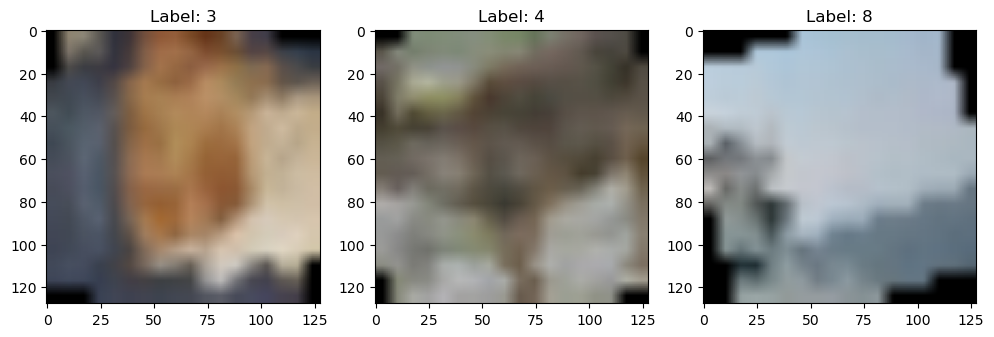

In [67]:
global_seeds(42)
example_data1, example_label1 = trainset[17]
example_data2, example_label2 = trainset[272]
example_data3, example_label3 = trainset[100]
# print(trainset.transform)
# print(example_data.shape)
image_np1 = example_data1.numpy().transpose((1, 2, 0))
image_np1 = np.uint8(((image_np1 * 0.25) + 0.5) * 255)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image_np1)  # permute to (height, width, channels)
plt.title(f"Label: {example_label1}")

image_np2 = example_data2.numpy().transpose((1, 2, 0))
image_np2 = np.uint8(((image_np2 * 0.25) + 0.5) * 255)
plt.subplot(132)
plt.imshow(image_np2)  # permute to (height, width, channels)
plt.title(f"Label: {example_label2}")

image_np3 = example_data3.numpy().transpose((1, 2, 0))
image_np3 = np.uint8(((image_np3 * 0.25) + 0.5) * 255)
plt.subplot(133)
plt.imshow(image_np3)  # permute to (height, width, channels)
plt.title(f"Label: {example_label3}")
plt.show()

In [75]:
#global_seeds(42)
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Input shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


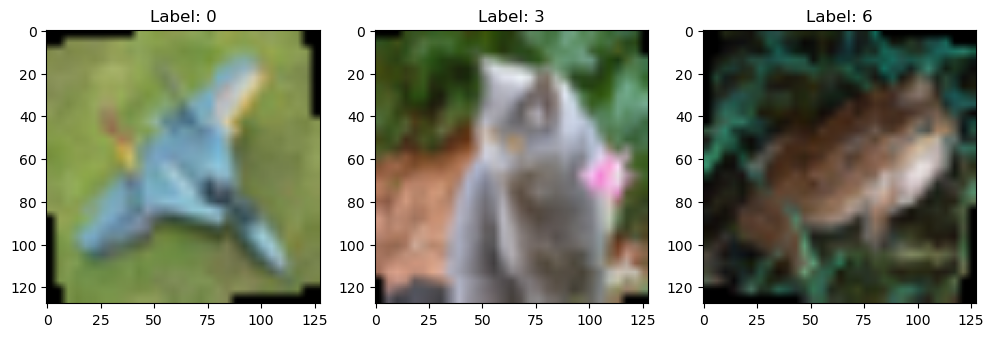

In [49]:
for batch in trainloader:
    # Unpack the batch into input data and labels (if applicable)
    inputs, labels = batch

    # Do something with the data in the current batch
    # For example, print the shapes of inputs and labels
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")

    example_data1, example_label1 = inputs[1], labels[1]
    example_data2, example_label2 = inputs[2], labels[2]
    example_data3, example_label3 = inputs[3], labels[3]
    image_np1 = example_data1.numpy().transpose((1, 2, 0))
    image_np1 = np.uint8(((image_np1 * 0.25) + 0.5) * 255)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(image_np1)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label1}")

    image_np2 = example_data2.numpy().transpose((1, 2, 0))
    image_np2 = np.uint8(((image_np2 * 0.25) + 0.5) * 255)
    plt.subplot(132)
    plt.imshow(image_np2)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label2}")

    image_np3 = example_data3.numpy().transpose((1, 2, 0))
    image_np3 = np.uint8(((image_np3 * 0.25) + 0.5) * 255)
    plt.subplot(133)
    plt.imshow(image_np3)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label3}")
    plt.show()
    break

In [76]:
#pretrained AlexNet model
num_classes = 10
model = models.alexnet(weights ='AlexNet_Weights.IMAGENET1K_V1')
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
model = model.cuda()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [77]:
num_epochs = 16
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.5)

In [78]:
class DisplayBlock:
    def __init__(self, names, time_slot=60):
        self.start_time = time.time()
        self.time_slot = time_slot
        self.annotations = []
        self.data = {}
        for name in names:
            self.data[name] = []
    
    def update(self, data_dict):
        for key in data_dict:
            self.data[key].append(data_dict[key])
        current_time = time.time() - self.start_time
        idx = len(self.data[key]) -1
        if len(self.annotations) == 0:
            if current_time > self.time_slot:
                self.annotations.append((idx, current_time))
        elif current_time - (self.annotations[-1][1]//self.time_slot)*self.time_slot > self.time_slot:
            self.annotations.append((idx, current_time))
    
    def draw(self):
        all_keys = list(self.data.keys())
        fig, ax = plt.subplots(nrows=1, ncols=len(all_keys))
        fig.set_figwidth(20)
        for idx in range(len(all_keys)):
            ax[idx].plot(self.data[all_keys[idx]])
            ax[idx].set_title(all_keys[idx])
            for an in self.annotations:
                ax[idx].annotate(f'{int(an[1])}s', xy=(an[0], self.data[all_keys[idx]][an[0]]),
                    xytext=(0, -40), textcoords="offset points",
                    va="center", ha="left",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
        display.clear_output(wait=True)
        plt.show()

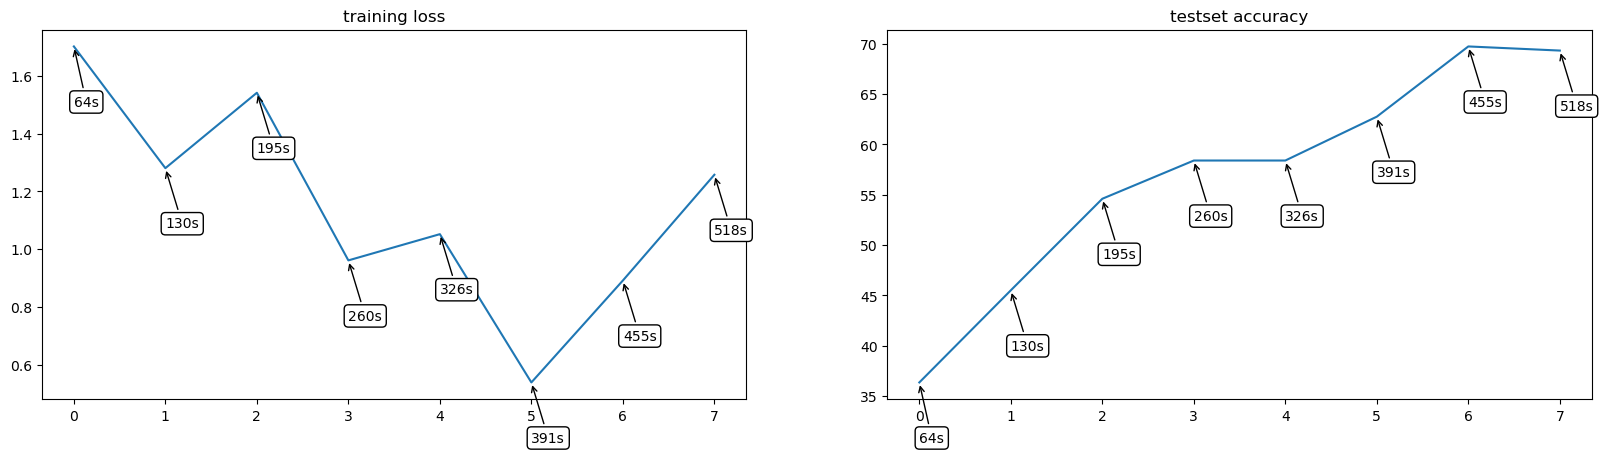

Epoch [8/16] - Training Loss: 0.86548, Testset Accuracy: 69.33%, Learning Rate: 0.00025


In [79]:
#global_seeds(42)
db = DisplayBlock(['training loss', 'testset accuracy'], time_slot=60)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels, in trainloader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images).cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()                
        running_loss += loss.item()
    
    scheduler.step()
    # obtain the current learning rate 
    current_lr = optimizer.param_groups[0]['lr']
    # print the loss and the learning rate
    # print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(trainingloader)}, Learning Rate: {current_lr}")
    print ("Training complete")

    # Evaluation on testset
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # find the index with the highest probability
            predicted = outputs.argmax(dim=1)
            # match the prediction with labels
            comparison = predicted == labels
            total_predictions += predicted.size(0)
            correct_predictions += comparison.sum()
    trainingloss = loss.item()
    testset_accuracy = (100 * correct_predictions / total_predictions).cpu()
    display.clear_output(wait=True)
    db.update({'training loss': trainingloss, 'testset accuracy': testset_accuracy})
    db.draw()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {(running_loss / len(trainloader)):.5f}, Testset Accuracy: {testset_accuracy:.2f}%, Learning Rate: {current_lr}")


print("Training finished")

In [ ]:
global_seeds(42)
True_label = []
predicted_label = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        # find the index with the highest probability
        predicted = outputs.argmax(dim=1)

        True_label.extend(labels.cpu().numpy())
        predicted_label.extend(predicted.cpu().numpy())

# Accuracy
accuracy = accuracy_score(True_label, predicted_label)
print(f'Accuracy: {accuracy:.2f}')

# Precision
precision = precision_score(True_label, predicted_label, average='weighted')
print(f'Precision: {precision:.2f}')

# Recall
recall = recall_score(True_label, predicted_label, average='weighted')
print(f'Recall: {recall:.2f}')

# F1 Score
f1 = f1_score(True_label, predicted_label, average='weighted')
print(f'F1 Score: {f1:.2f}')

# Classification Report
class_report = classification_report(True_label, predicted_label)
print('Classification Report:')
print(class_report)

# Execution-exact

In [ ]:
num_iter = 5
num_epochs = 16
learning_rate = 0.001

In [ ]:
sample_output = []
for iterations in num_iter:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.5)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels, in trainloader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images).cuda()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()                
            running_loss += loss.item()
        
        scheduler.step()
        # obtain the current learning rate 
        # current_lr = optimizer.param_groups[0]['lr']
        # print the loss and the learning rate
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(trainloader)}")
    print (f"{iterations} Training complete")
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # find the index with the highest probability
            predicted = outputs.argmax(dim=1)
            # match the prediction with labels
            comparison = predicted == labels
            total_predictions += predicted.size(0)
            correct_predictions += comparison.sum()
    trainingloss = loss.item()
    testset_accuracy = (100 * correct_predictions / total_predictions).cpu()
    print(f"Testset Accuracy: {testset_accuracy:.2f}%")
    sample_output.append(testset_accuracy)

In [5]:
sample_output = [84.36, 85.21, 84.66, 85.01, 84.03, 84.88, 84.73, 85.10]

In [6]:
sample_mean = np.mean(sample_output)
sample_std = np.std(sample_output)
sample_size = len(sample_output)
Z = 1.96
CI_lowerbound = sample_mean - Z*sample_std/np.sqrt(sample_size)
CI_upperbound = sample_mean + Z*sample_std/np.sqrt(sample_size)
print(f"The 95% confidence interval = [{CI_lowerbound:.2f},{CI_upperbound:.2f}]")

The 95% confidence interval = [84.49082814967356,85.00417185032644]


In [9]:
print(np.sqrt(sample_size))

2.8284271247461903


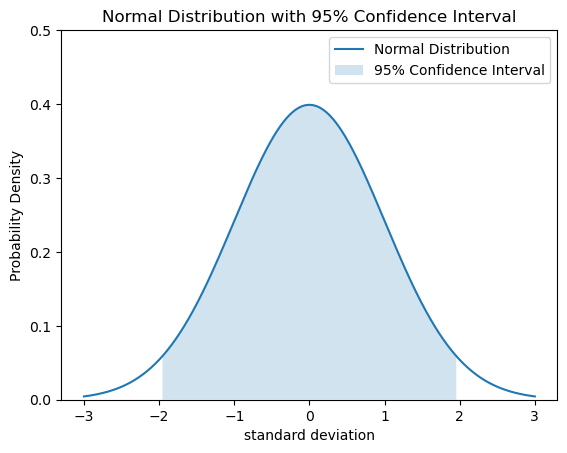

In [12]:
mean = 0
std_dev = 1
confidence_interval = 1.96
x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 1000)  # Adjust the range as needed
y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std_dev**2))
plt.plot(x, y, label='Normal Distribution')
lower_bound = mean - confidence_interval * std_dev
upper_bound = mean + confidence_interval * std_dev

plt.fill_between(x, 0, y, where=(x >= lower_bound) & (x <= upper_bound), alpha=0.2, label='95% Confidence Interval')
plt.xlabel('standard deviation')
plt.ylabel('Probability Density')
plt.ylim([0, 0.5])
plt.title('Normal Distribution with 95% Confidence Interval')
plt.legend()
plt.show()